In [1]:
#Dataloader example

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
from mb_utils.src.logging import logger
from mb_pytorch.dataloader.loader import DataLoader

In [4]:
k =DataLoader('../scripts/loader_y.yaml') #load the data

In [5]:
out1,out2,_,_ =k.data_load(logger=logger)

50row [00:00, 20819.54row/s]
50row [00:00, 26054.81row/s]


In [6]:
for i in out1:
    if logger:
        #logger.info("self.trainloader [0] = {}".format(i['image']))
        logger.info("self.trainloader keys = {}".format(i.keys()))
        logger.info("self.trainloader shape = {}".format(i['image'].shape))
        if 'label' in i.keys():
            logger.info("self.trainloader label = {}".format(i['label']))
    break

Wed 04:16:34,083 INF self.trainloader keys = dict_keys(['image'])                                                                    
Wed 04:16:34,086 INF self.trainloader shape = torch.Size([4, 3, 28, 28])                                                             


In [7]:
k.transforms_final  #transforms applied to the data

Compose(
    ToTensor()
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=(-0.1, 0.1))
)

In [8]:
k.data_dict #original yaml data

{'data': {'from_datasets': 'CIFAR10',
  'from_file': True,
  'work_dir': '/home/malav/mb_pytorch/data/',
  'file': '/home/malav/mb_pytorch/data/csv/file_data.csv',
  'use_img_dir': True,
  'img_dir': '/home/malav/mb_pytorch/data/images1/',
  'thresholding_pd': 0},
 'train_params': {'batch_size': 4,
  'num_workers': 4,
  'pin_memory': True,
  'shuffle': True},
 'test_params': {'batch_size': 4,
  'num_workers': 4,
  'pin_memory': True,
  'shuffle': True},
 'transforms_list': {'transform': True,
  'resize': {'val': False, 'args': {'size': [256, 256]}},
  'random_crop': {'val': False, 'args': {'size': [224, 224]}},
  'random_horizontal_flip': {'val': True, 'args': {'p': 0.5}},
  'random_vertical_flip': {'val': False, 'args': {'p': 0.5}},
  'random_rotation': {'val': True, 'args': {'degrees': 90}},
  'random_grayscale': {'val': False, 'args': {'p': 0.1}},
  'random_color_jitter': {'val': True,
   'args': {'brightness': 0.4,
    'contrast': 0.4,
    'saturation': 0.4,
    'hue': 0.1}},
  'no

In [9]:
from mb_pytorch.utils.viewer import show_images
show_images?

Signature: show_images(imgs, figsize=(10.0, 10.0))
Docstring:
Displays a single image or list of images. 
Args:
    imgs (Union[List[torch.Tensor], torch.Tensor]): A list of images
        of shape (3, H, W) or a single image of shape (3, H, W).
    figsize (Tuple[float, float]): size of figure to display.
Returns:
    None
File:      ~/.local/lib/python3.8/site-packages/mb_pytorch/utils/viewer.py
Type:      function


torch.Size([4, 3, 28, 28])


TypeError: Invalid shape (3, 28, 28) for image data

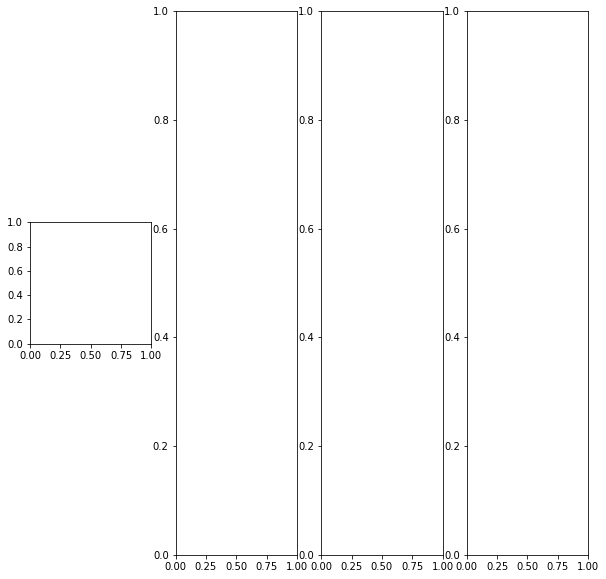

In [10]:
for i in out2:
    print(i['image'].shape)
    i_list = i['image'].tolist()
    show_images(i_list)
    break